# Problem Statement

Your client is an Insurance company and they need your help in building a model to predict the propensity to pay renewal premium and build an incentive plan for its agents to maximise the net revenue (i.e. renewals - incentives given to collect the renewals) collected from the policies post their issuance.

 

You have information about past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.

 

In addition to the information above, the client has provided the following relationships:

    Expected effort in hours put in by an agent for incentives provided; and
    Expected increase in chances of renewal, given the effort from the agent.

 

Given the information, the client wants you to predict the propensity of renewal collection and create an incentive plan for agents (at policy level) to maximise the net revenues from these policies.

 
## EVALUATION CRITERIA

Your solutions will be evaluated on 2 criteria:

    The base probability of receiving a premium on a policy without considering any incentive
    The monthly incentives you will provide on each policy to maximize the net revenue 

### Part A:

The probabilities predicted by the participants would be evaluated using AUC ROC score.

 
### Part B:

The net revenue across all policies will be calculated in the following manner:

 



    pbenchmark is the renewal probability predicted using a benchmark model by the insurance company

 

    ∆p (% Improvement in renewal probability*pbenchmark) is the improvement in renewal probability calculated from the agent efforts in hours

 

    ‘Premium on policy’ is the premium paid by the policy holder for the policy in consideration

 

    ‘Incentive on policy’ is the incentive given to the agent for increasing the chance of renewal (estimated by the participant) for each policy

 

The following curve provide the relationship between extra effort in hours invested by the agent with Incentive to the agent and % improvement in renewal probability vs agent effort in hours.

 

    Relationship b/w Extra efforts in hours invested by an agent and Incentive to agent. After a point more incentives does not convert to extra efforts.

 

Equation for the effort-incentives curve: Y = 10*(1-exp(-X/400))

 

    Relationship between % improvement in renewal probability vs Agent effort in hours. The renewal probability cannot be improved beyond a certain level even with more efforts.

 

Equation for the % improvement in renewal prob vs effort curve: Y = 20*(1-exp(-X/5))

 

Note: The client has used sophisticated psychological research to arrive at these relationships and you can assume them to be true.

 

 

Overall Ranking at the leaderboard would be done using the following equation:

 

Combined Score = w1*AUC-ROC value + w2*(net revenue collected from all policies)*lambda

 

Where -

w1 = 0.7

w2 = 0.3

lambda is a normalizing factor

 
## Public and Private Split:

 

Public leaderboard is based on 40% of the policies, while private leaderboard will be evaluated on remaining 60% of policies in the test dataset.

 
Data
train.csv

It contains training data for customers along with renewal premium status (Renewed or Not?)

## Data
### train.csv

It contains training data for customers along with renewal premium status (Renewed or Not?)

 

|||
|--- |--- |
|Variable|Definition|
|||
|--- |--- |
|id|Unique ID of the policy|
|perc_premium_paid_by_cash_credit|Percentage of premium amount paid by cash or credit card|
|age_in_days|Age in days of policy holder|
|Income|Monthly Income of policy holder|
|Count_3-6_months_late|No of premiums late by 3 to 6 months|
|Count_6-12_months_late|No  of premiums late by 6 to 12 months|
|Count_more_than_12_months_late|No of premiums late by more than 12 months|
|application_underwriting_score|Underwriting Score of the applicant at the time of application (No applications under the score of 90 are insured)|
|no_of_premiums_paid|Total premiums paid on time till now|
|sourcing_channel|Sourcing channel for application|
|residence_area_type|Area type of Residence (Urban/Rural)|
|premium|Monthly premium amount|
|renewal|Policy Renewed? (0 - not renewed, 1 - renewed|

### test.csv

Additionally test file contains premium which is required for the optimizing the incentives for each policy in the test set.

|||
|--- |--- |
|Variable|Definition|
|||
|--- |--- |
|id|Unique ID of the policy|
|perc_premium_paid_by_cash_credit|Percentage of premium amount paid by cash or credit card|
|age_in_days|Age in days of policy holder|
|Income|Monthly Income of policy holder|
|Count_3-6_months_late|No of premiums late by 3 to 6 months|
|Count_6-12_months_late|No  of premiums late by 6 to 12 months|
|Count_more_than_12_months_late|No of premiums late by more than 12 months|
|application_underwriting_score|Underwriting Score of the applicant at the time of application (No applications under the score of 90 are insured)|
|no_of_premiums_paid|Total premiums paid on time till now|
|sourcing_channel|Sourcing channel for application|
|residence_area_type|Area type of Residence (Urban/Rural)|
|premium|Monthly premium amount|

	
### sample_submission.csv

Please submit as per the given sample submission format only

 

|||
|--- |--- |
|Variable|Definition|
|||
|--- |--- |
|id|Unique ID for the policy|
|renewal|Predicted Renewal Probability|
|incentives|Incentives for agent on policy|
 








In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

In [113]:
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 500)

In [2]:
# file pahts

raw_data_path = os.path.join(os.path.pardir, 'data', 'raw')
train_data_path = os.path.join(raw_data_path, 'train.csv')
test_data_path = os.path.join(raw_data_path, 'test.csv')

submission_data_path = os.path.join(os.path.pardir,'data','external')

processed_data_path = os.path.join(os.path.pardir,'data','processed')
train_processed_path = os.path.join(processed_data_path, 'train_processed.csv')
test_processed_path = os.path.join(processed_data_path, 'test_processed.csv')

In [3]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
sub = pd.read_csv(os.path.join(submission_data_path,'Sample_Submission.csv'))

In [4]:
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train,test],ignore_index=True)

# =====================================================

In [5]:
#data[data.source == 'train'].describe().T
#data[data.source == 'test'].describe().T

In [6]:
data['age_in_years'] = round(data.age_in_days/365.25)

In [7]:
data['premium_prc_of_income'] = round(data.premium/data.Income,4)

In [8]:
data['Income_in_k'] = round(data['Income']/1000)

In [9]:
data = pd.get_dummies(data, prefix=['residence_area_type','source','sourcing_channel'], drop_first=True)

In [10]:
data['perc_premium_zero'] = 0
data['perc_premium_full'] = 0
data.loc[data['perc_premium_paid_by_cash_credit'] == 0, 'perc_premium_zero'] = 1
data.loc[data['perc_premium_paid_by_cash_credit'] == 1, 'perc_premium_full'] = 1

In [11]:
#data.isnull().sum()

In [12]:
#data.describe().T

In [13]:
train_processed = data[data['source_train']==1]
test_processed = data[data['source_train']==0]
train_processed = train_processed.drop(['source_train'], axis=1)
test_processed = test_processed.drop(['source_train'], axis=1)

train_processed.to_csv(train_processed_path, index=False)
test_processed.to_csv(test_processed_path, index=False)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [14]:
data.loc[data['Count_3-6_months_late'].isnull(), 'Count_3-6_months_late'] = 0
data.loc[data['Count_6-12_months_late'].isnull(), 'Count_6-12_months_late'] = 0
data.loc[data['Count_more_than_12_months_late'].isnull(), 'Count_more_than_12_months_late'] = 0

In [15]:
data = data.dropna()

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [43]:
#data[data.application_underwriting_score.isnull()].describe().T

In [44]:
#data[data['Count_more_than_12_months_late'].isnull()].describe().T

In [45]:
#data[(data.no_of_premiums_paid == 3) & (data['Count_6-12_months_late'].isnull())]

# =====================================================

## Visualisation

In [74]:
grade_pivot = pd.pivot_table(data,values='id',index=['residence_area_type','sourcing_channel'], aggfunc='count')

In [82]:
grade_pivot_renewal = pd.pivot_table(data,values='renewal',index=['residence_area_type','sourcing_channel'], aggfunc='sum')

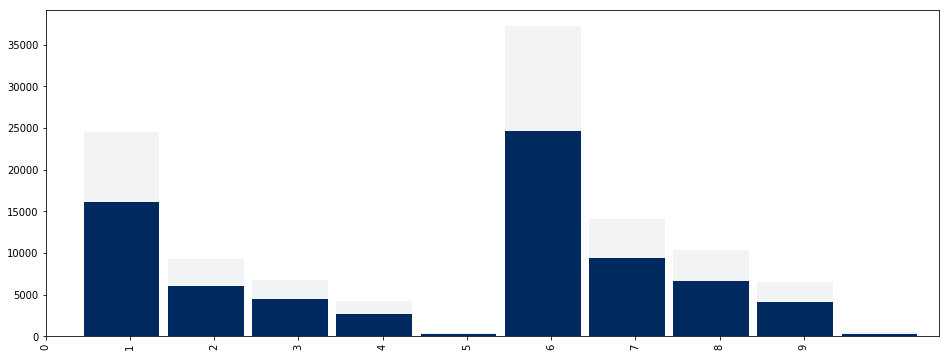

In [86]:
w=0.9
ax = grade_pivot.plot(kind='bar',color='#F1F3F4',width=w,position=0,stacked=False, align = 'edge',legend=False,  figsize=(16,6), use_index=False)
renewal_color = '#002960'
grade_pivot_renewal.plot(kind='bar',color=renewal_color,width=w,position=0,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
plt.show()

# =====================================================

In [93]:
def submission(df_submission, filename):
    # submission file
    submission_data_path = os.path.join(os.path.pardir,'data','external')
    submission_file_path = os.path.join(submission_data_path, filename)
    # write to the file
    df_submission.to_csv(submission_file_path, index=False)

In [21]:
meanRenewal = 0.937410
df_submission = sub.copy()
df_submission.renewal = meanRenewal
filename = 'Mean_Submission.csv'
submission(df_submission, filename)

In [26]:
oneRenewal = 1
df_submission = sub.copy()
df_submission.renewal = oneRenewal
filename = 'one_submission.csv'
submission(df_submission, filename)

In [36]:
np.random.seed(42)
df_submission = sub.copy()
df_submission.renewal = np.random.random(size=len(df_submission))
filename = 'random_submission.csv'
submission(df_submission, filename)

# =====================================================

In [16]:
#data.T

In [17]:
df = data[data.source_train == 1].copy()

In [18]:
to_drop = ['renewal', 'source_train','age_in_days', 'Income']
y = df['renewal']
X = df.drop(to_drop, axis=1)

In [19]:
# file pahts
X_path = os.path.join(processed_data_path, 'X.csv')
y_path = os.path.join(processed_data_path, 'y.csv')
X_train_path = os.path.join(processed_data_path, 'X_train.csv')
y_train_path = os.path.join(processed_data_path, 'y_train.csv')
X_test_path = os.path.join(processed_data_path, 'X_test.csv')
y_test_path = os.path.join(processed_data_path, 'y_test.csv')

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False)
X_train.to_csv(X_train_path, index=False)
y_train.to_csv(y_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_test.to_csv(y_test_path, index=False)

# =====================================================

In [22]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# file pahts
model_data_path = os.path.join(os.path.pardir,'models')

import pickle
def modelpersistence(alg, filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'wb')
    pickle.dump(alg, model_file_pickle)
    model_file_pickle.close()
    
def modelload(filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'r')
    alg_loaded = pickle.load(model_file_pickle)
    model_file_pickle.close()
    return alg_loaded

# file pahts
submission_data_path = os.path.join(os.path.pardir,'data','external')

In [23]:
# file pahts
processed_data_path = os.path.join(os.path.pardir,'data','processed')
X_path = os.path.join(processed_data_path, 'X.csv')
y_path = os.path.join(processed_data_path, 'y.csv')
X_train_path = os.path.join(processed_data_path, 'X_train.csv')
y_train_path = os.path.join(processed_data_path, 'y_train.csv')
X_test_path = os.path.join(processed_data_path, 'X_test.csv')
y_test_path = os.path.join(processed_data_path, 'y_test.csv')

figures_data_path = os.path.join(os.path.pardir, 'reports', 'figures')

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path,header=None,names=['renewal'])
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path,header=None,names=['renewal'])

In [27]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [28]:
IDcol = ['id']
target = 'renewal'
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [24]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # fit file path
    filename_path = os.path.join(submission_data_path, filename)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict probabilities for class 1 in training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predictions = alg.predict_proba(dtrain[predictors])[:, 1]
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=kfold, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("AUC ROC train: %.4g" % metrics.roc_auc_score(dtrain[target].values, dtrain_predictions))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    modelpersistence(alg, filename)
    
    #Predict probabilities for class 1 in testing data:
    #dtest[target] = alg.predict(dtest[predictors])
    dtest[target] = alg.predict_proba(dtest[predictors])[:, 1]
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename_path, index=False)
    #return np.mean(cv_score), metrics.mean_squared_error(dtrain[target].values, dtrain_predictions

In [25]:
def testprediction(filename):
    # fit filt path
    filename_path = os.path.join(submission_data_path, filename)
    
    test_predictions = pd.read_csv(filename_path)
    roc_auc_score = metrics.roc_auc_score(y_test[target], test_predictions[target])
    
    curvelab = 'AUC=' + str(round(roc_auc_score,5))

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test[target], test_predictions[target])

    plt.plot(fpr, tpr, label = curvelab)
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for '+ target + ' classifier on test')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(figures_data_path, filename + '.png'), bbox_inches='tight')
    plt.show()
    #return roc_auc_score

In [26]:
def modeltest(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # fit filt path
    filename_path = os.path.join(submission_data_path, filename)
    
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict_proba(dtrain[predictors])[:, 1]
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=kfold, scoring='roc_auc')
    return np.mean(cv_score), metrics.roc_auc_score(dtrain[target].values, dtrain_predictions)

### Logistic Regression


Model Report
AUC ROC train: 0.6263
CV Score : Mean - 0.6275 | Std - 0.02082 | Min - 0.5866 | Max - 0.6531


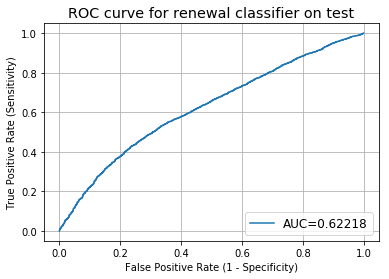

In [29]:
from sklearn.linear_model import LogisticRegression
alg10 = LogisticRegression(class_weight={0: 0.062548, 1: 0.937452})
modelfit(alg10, train, test, predictors, target, IDcol, 'alg10.csv')
testprediction('alg10.csv')

    because data is unbalanced I will use parameter: class_weight='balanced'


Model Report
AUC ROC train: 0.8327
CV Score : Mean - 0.8317 | Std - 0.01305 | Min - 0.81 | Max - 0.8518


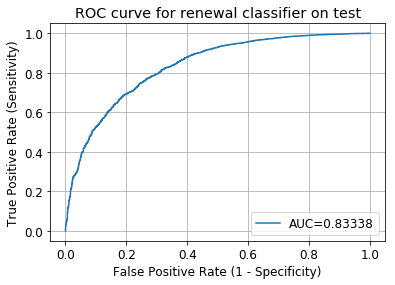

In [30]:
from sklearn.linear_model import LogisticRegression
alg11 = LogisticRegression(class_weight='balanced')
modelfit(alg11, train, test, predictors, target, IDcol, 'alg11.csv')
testprediction('alg11.csv')

# Logistic Regression Scaled MinMaxScaler

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [32]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8339
CV Score : Mean - 0.8328 | Std - 0.01332 | Min - 0.8092 | Max - 0.8536


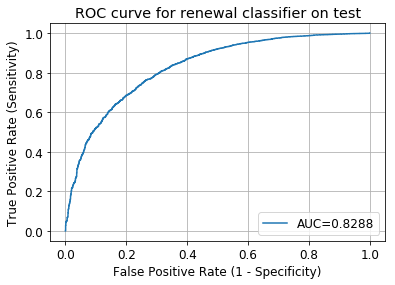

In [33]:
from sklearn.linear_model import LogisticRegression
alg12 = LogisticRegression(class_weight='balanced')
modelfit(alg12, train, test, predictors, target, IDcol, 'alg12.csv')
testprediction('alg12.csv')

# Logistic Regression Scaled StandardScaler

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [35]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.835
CV Score : Mean - 0.8337 | Std - 0.01293 | Min - 0.8105 | Max - 0.8534


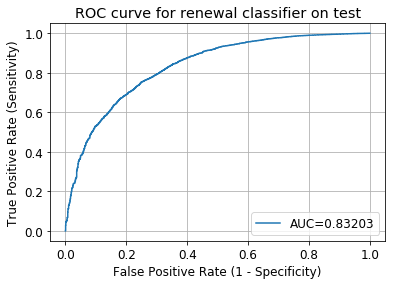

In [36]:
from sklearn.linear_model import LogisticRegression
alg13 = LogisticRegression(class_weight='balanced')
modelfit(alg13, train, test, predictors, target, IDcol, 'alg13.csv')
testprediction('alg13.csv')

# Logistic Regression Scaled RobustScaler

In [37]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [38]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8349
CV Score : Mean - 0.8337 | Std - 0.01293 | Min - 0.8105 | Max - 0.8534


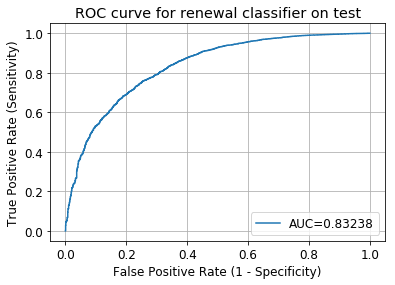

In [39]:
from sklearn.linear_model import LogisticRegression
alg14 = LogisticRegression(class_weight='balanced')
modelfit(alg14, train, test, predictors, target, IDcol, 'alg14.csv')
testprediction('alg14.csv')

# ==================================

# Decisions Trees

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(np.empty(X_train.shape), columns=X_train.columns)
X_test_scaled = pd.DataFrame(np.empty(X_test.shape), columns=X_test.columns)
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test_scaled[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [41]:
train = pd.merge(X_train_scaled, y_train, left_index=True, right_index=True)
test = pd.merge(X_test_scaled, y_test, left_index=True, right_index=True)


Model Report
AUC ROC train: 0.8319
CV Score : Mean - 0.8219 | Std - 0.01163 | Min - 0.8042 | Max - 0.839


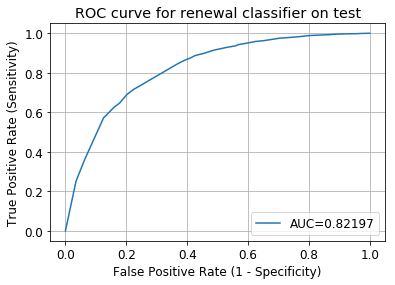

In [42]:
from sklearn.tree import DecisionTreeClassifier
alg20 = DecisionTreeClassifier(
    max_depth = 6,
    criterion='entropy',
    class_weight='balanced',
    min_weight_fraction_leaf=0.01,
    random_state=42)
modelfit(alg20, train, test, predictors, target, IDcol, 'alg20.csv')
testprediction('alg20.csv')

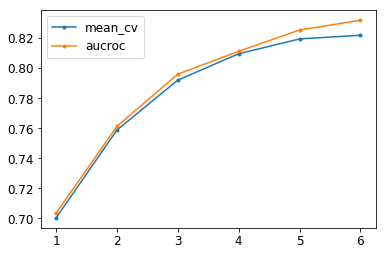

In [43]:
points=[]
for i in range(1,7):
    alg_name='alg20_%d'%i
    file_name = 'alg20_%d'%i
    alg_name = DecisionTreeClassifier(
                                    max_depth = i,
                                    criterion='entropy',
                                    class_weight='balanced',
                                    min_weight_fraction_leaf=0.01,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [44]:
points.to_csv('alg20_max_depth.csv',index=False)

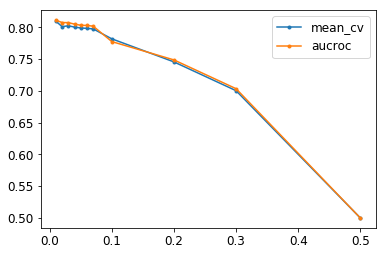

In [47]:
points=[]
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.2,0.3,0.5]:
    alg_name='alg20_%d'%i
    file_name = 'alg20_%d'%i
    alg_name = DecisionTreeClassifier(
                                    max_depth = 4,
                                    criterion='entropy',
                                    class_weight='balanced',
                                    min_weight_fraction_leaf=i,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

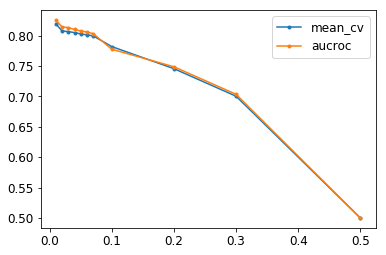

In [46]:
points=[]
for i in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.2,0.3,0.5]:
    alg_name='alg20_%d'%i
    file_name = 'alg20_%d'%i
    alg_name = DecisionTreeClassifier(
                                    max_depth = 5,
                                    criterion='entropy',
                                    class_weight='balanced',
                                    min_weight_fraction_leaf=i,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [48]:
points.to_csv('alg20_min_weight_fraction_leaf.csv',index=False)


Model Report
AUC ROC train: 0.8253
CV Score : Mean - 0.8194 | Std - 0.01118 | Min - 0.8033 | Max - 0.8375


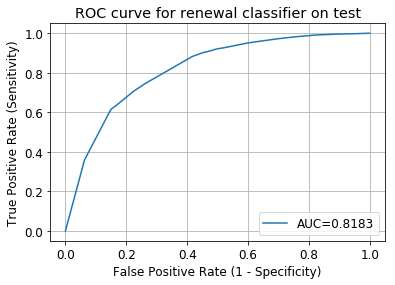

In [50]:
from sklearn.tree import DecisionTreeClassifier
alg21 = DecisionTreeClassifier(
    max_depth = 5,
    criterion='entropy',
    class_weight='balanced',
    min_weight_fraction_leaf=0.01,
    random_state=42)
modelfit(alg21, train, test, predictors, target, IDcol, 'alg21.csv')
testprediction('alg21.csv')

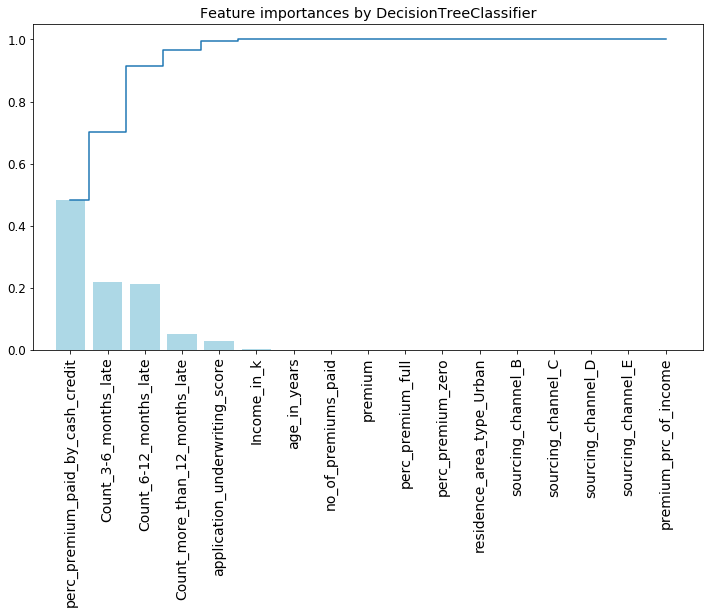

In [51]:
importances = alg21.feature_importances_
feat_names = train[predictors].columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Random Forest Classifier


Model Report
AUC ROC train: 0.8477
CV Score : Mean - 0.8356 | Std - 0.01095 | Min - 0.8169 | Max - 0.8557


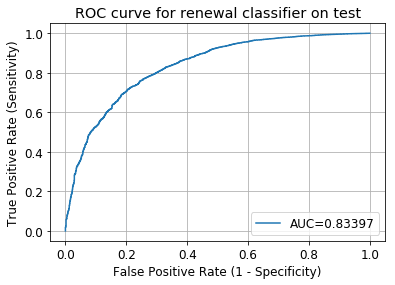

In [52]:
from sklearn.ensemble import RandomForestClassifier

alg30 = RandomForestClassifier(
    max_depth = 6,
    #min_samples_split=30, 
    n_estimators= 100,
    class_weight='balanced',
    random_state=42)
modelfit(alg30, train, test, predictors, target, IDcol, 'alg30.csv')
testprediction('alg30.csv')

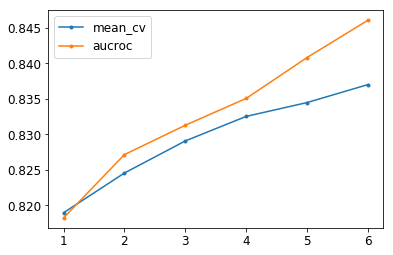

In [53]:
points=[]
for i in range(1,7):
    alg_name='alg30_%d'%i
    file_name = 'alg30_%d'%i
    alg_name = RandomForestClassifier(
                                    n_estimators=50,
                                    max_depth=i,
                                    #min_samples_split=15,
                                    n_jobs=-1,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [54]:
points.to_csv('alg30_max_depth.csv',index=False)

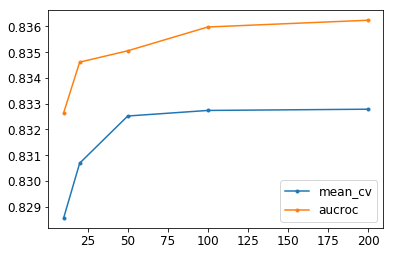

In [55]:
points=[]
for i in [10,20,50,100,200]:
    alg_name='alg30_%d'%i
    file_name = 'alg30_%d'%i
    alg_name = RandomForestClassifier(
                                    n_estimators=i,
                                    max_depth=4,
                                    #min_samples_split=15,
                                    n_jobs=-1,
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [56]:
points.to_csv('alg30_n_estimators.csv',index=False)


Model Report
AUC ROC train: 0.8376
CV Score : Mean - 0.8333 | Std - 0.01097 | Min - 0.8146 | Max - 0.8518


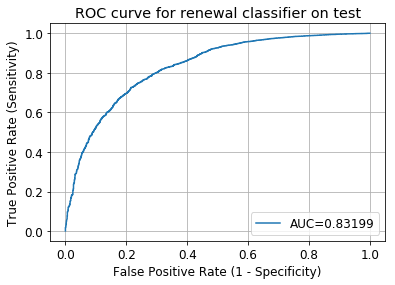

In [57]:
alg31 = RandomForestClassifier(
    max_depth = 4,
    #min_samples_split=30, 
    n_estimators= 100,
    class_weight='balanced',
    random_state=42)
modelfit(alg31, train, test, predictors, target, IDcol, 'alg31.csv')
testprediction('alg31.csv')

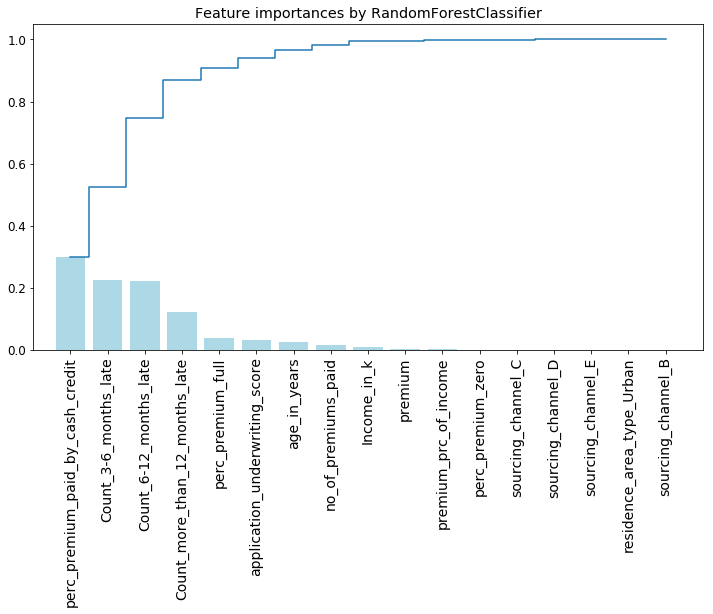

In [58]:
importances = alg31.feature_importances_
feat_names = train[predictors].columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForestClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

# Gradient Boosting Classifier


Model Report
AUC ROC train: 0.8503
CV Score : Mean - 0.7508 | Std - 0.05577 | Min - 0.6112 | Max - 0.8121


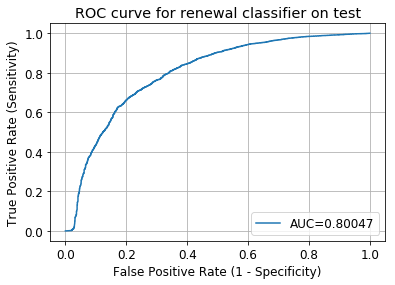

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
alg40 = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=4,
    #class_weight='balanced', 
    learning_rate=1.0, 
    random_state=42)
modelfit(alg40, train, test, predictors, target, IDcol, 'alg40.csv')
testprediction('alg40.csv')

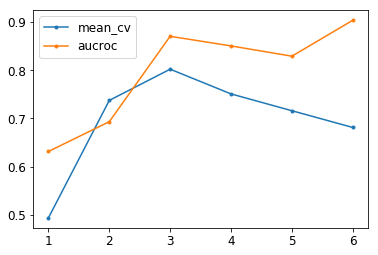

In [60]:
points=[]
for i in range(1,7):
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=100, 
                                    max_depth=i,
                                    #class_weight='balanced', 
                                    learning_rate=1.0, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [61]:
points.to_csv('alg40_max_depth.csv',index=False)

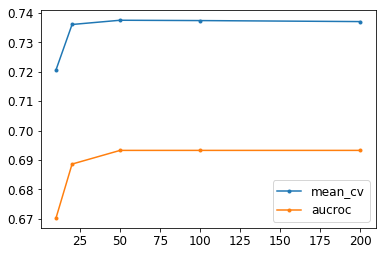

In [62]:
points=[]
for i in [10,20,50,100,200]:
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=i, 
                                    max_depth=2,
                                    #class_weight='balanced', 
                                    learning_rate=1.0, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [63]:
points.to_csv('alg40_n_estimators.csv',index=False)

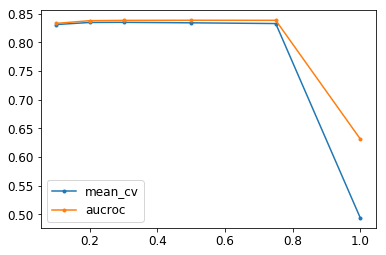

In [64]:
points=[]
for i in [0.1,0.2,0.3,0.5,0.75,1]:
    alg_name='alg40_%d'%i
    file_name = 'alg40_%d'%i
    alg_name = GradientBoostingClassifier(
                                    n_estimators=50, 
                                    max_depth=1,
                                    #class_weight='balanced', 
                                    learning_rate=i, 
                                    random_state=42)
    mean_temp, aucroc_temp = modeltest(alg_name, train, test, predictors, target, IDcol, file_name)
    points.append([i, mean_temp, aucroc_temp])
points = pd.DataFrame(points, columns=['max_depth','mean_cv','aucroc'])
plt.plot(points['max_depth'], points['mean_cv'], '.-',label='mean_cv')
plt.plot(points['max_depth'], points['aucroc'], '.-',label='aucroc')
plt.legend()
plt.show()

In [65]:
points.to_csv('alg40_learning_rate.csv',index=False)


Model Report
AUC ROC train: 0.8642
CV Score : Mean - 0.8283 | Std - 0.01206 | Min - 0.8124 | Max - 0.8543


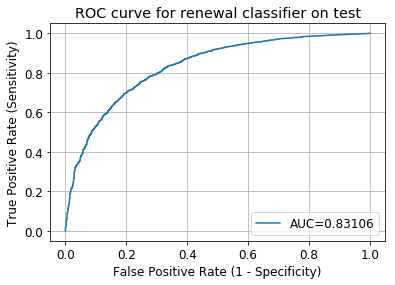

In [67]:
alg41 = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    #class_weight='balanced', 
    learning_rate=0.5, 
    random_state=42)
modelfit(alg41, train, test, predictors, target, IDcol, 'alg41.csv')
testprediction('alg41.csv')

# ================================

In [22]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# file pahts
model_data_path = os.path.join(os.path.pardir,'models')

import pickle
def modelpersistence(alg, filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'wb')
    pickle.dump(alg, model_file_pickle)
    model_file_pickle.close()
    
def modelload(filename):
    model_file_path = os.path.join(model_data_path, filename + '.pkl')
    model_file_pickle = open(model_file_path, 'r')
    alg_loaded = pickle.load(model_file_pickle)
    model_file_pickle.close()
    return alg_loaded

# file pahts
submission_data_path = os.path.join(os.path.pardir,'data','external')

In [ ]:
train_processed = data[data['source_train']==1]
test_processed = data[data['source_train']==0]
train_processed = train_processed.drop(['source_train'], axis=1)
test_processed = test_processed.drop(['source_train'], axis=1)

train_processed.to_csv(train_processed_path, index=False)
test_processed.to_csv(test_processed_path, index=False)

In [71]:
train = pd.read_csv(train_processed_path)
test = pd.read_csv(test_processed_path)

In [77]:
train.loc[train['Count_3-6_months_late'].isnull(), 'Count_3-6_months_late'] = 0
train.loc[train['Count_6-12_months_late'].isnull(), 'Count_6-12_months_late'] = 0
train.loc[train['Count_more_than_12_months_late'].isnull(), 'Count_more_than_12_months_late'] = 0

train.loc[train['application_underwriting_score'].isnull(), 'application_underwriting_score'] = 999

test.loc[test['Count_3-6_months_late'].isnull(), 'Count_3-6_months_late'] = 0
test.loc[test['Count_6-12_months_late'].isnull(), 'Count_6-12_months_late'] = 0
test.loc[test['Count_more_than_12_months_late'].isnull(), 'Count_more_than_12_months_late'] = 0

test.loc[test['application_underwriting_score'].isnull(), 'application_underwriting_score'] = 999

In [80]:
IDcol = ['id']
target = 'renewal'
predictors = [x for x in train.columns if x not in [target]+IDcol]

In [81]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # fit file path
    filename_path = os.path.join(submission_data_path, filename)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict probabilities for class 1 in training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predictions = alg.predict_proba(dtrain[predictors])[:, 1]
    kfold = StratifiedKFold(n_splits=10, random_state=42)
    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=kfold, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("AUC ROC train: %.4g" % metrics.roc_auc_score(dtrain[target].values, dtrain_predictions))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    modelpersistence(alg, filename)
    
    #Predict probabilities for class 1 in testing data:
    #dtest[target] = alg.predict(dtest[predictors])
    dtest[target] = alg.predict_proba(dtest[predictors])[:, 1]
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename_path, index=False)
    #return np.mean(cv_score), metrics.mean_squared_error(dtrain[target].values, dtrain_predictions

### Logistic Regression Final Submission

In [83]:
from sklearn.linear_model import LogisticRegression
salg11 = LogisticRegression(class_weight='balanced')
modelfit(salg11, train, test, predictors, target, IDcol, 'salg11.csv')


Model Report
AUC ROC train: 0.8269
CV Score : Mean - 0.8254 | Std - 0.009643 | Min - 0.8093 | Max - 0.8376


In [88]:
logistic_submission = pd.read_csv(os.path.join(submission_data_path, 'sample_submission.csv'))
temp = pd.read_csv(os.path.join(submission_data_path, 'salg11.csv'))
logistic_submission['renewal'] = temp['renewal']

In [94]:
df_submission = logistic_submission
filename = 'logistic_submission.csv'
submission(df_submission, filename)

### Gradient Boosting Regression Submission

In [95]:
salg41 = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    #class_weight='balanced', 
    learning_rate=0.5, 
    random_state=42)
modelfit(salg41, train, test, predictors, target, IDcol, 'salg41.csv')


Model Report
AUC ROC train: 0.8615
CV Score : Mean - 0.835 | Std - 0.007477 | Min - 0.8206 | Max - 0.845


In [96]:
gradient_submission = pd.read_csv(os.path.join(submission_data_path, 'sample_submission.csv'))
temp = pd.read_csv(os.path.join(submission_data_path, 'salg41.csv'))
gradient_submission['renewal'] = temp['renewal']

In [97]:
df_submission = gradient_submission
filename = 'gradient_submission.csv'
submission(df_submission, filename)

### Random Forest Submission

In [98]:
from sklearn.ensemble import RandomForestClassifier

salg30 = RandomForestClassifier(
    max_depth = 6,
    #min_samples_split=30, 
    n_estimators= 100,
    class_weight='balanced',
    random_state=42)
modelfit(salg30, train, test, predictors, target, IDcol, 'salg30.csv')


Model Report
AUC ROC train: 0.8458
CV Score : Mean - 0.8366 | Std - 0.007347 | Min - 0.8245 | Max - 0.8456


In [99]:
forest_submission = pd.read_csv(os.path.join(submission_data_path, 'sample_submission.csv'))
temp = pd.read_csv(os.path.join(submission_data_path, 'salg30.csv'))
forest_submission['renewal'] = temp['renewal']

In [100]:
df_submission = forest_submission
filename = 'forest_submission.csv'
submission(df_submission, filename)

# ==========================================

In [103]:
test.T

,0,1,2,3,4,5,6,7,8,9,...,34214,34215,34216,34217,34218,34219,34220,34221,34222,34223
Count_3-6_months_late,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,3.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
Count_6-12_months_late,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Count_more_than_12_months_late,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Income,51150.000000,285140.000000,186030.000000,123540.000000,200020.000000,245130.000000,388050.000000,99880.000000,360040.000000,510040.000000,...,127570.000000,40840.00000,35920.00000,36110.000000,445000.000000,110240.000000,125090.000000,196570.000000,212150.000000,89190.000000
age_in_days,27384.000000,23735.000000,17170.000000,16068.000000,10591.000000,16065.000000,17167.000000,20085.000000,23008.000000,21906.000000,...,16803.000000,23739.00000,14244.00000,15341.000000,17894.000000,20810.000000,19353.000000,18264.000000,16798.000000,24467.000000
application_underwriting_score,99.890000,98.930000,999.000000,99.000000,99.170000,98.880000,99.000000,98.400000,99.880000,99.890000,...,99.100000,97.51000,99.88000,99.600000,99.420000,97.520000,99.620000,98.580000,98.880000,98.000000
id,649.000000,81136.000000,70762.000000,53935.000000,15476.000000,64797.000000,67412.000000,44241.000000,5069.000000,16615.000000,...,24582.000000,79939.00000,63759.00000,63725.000000,37116.000000,81988.000000,30326.000000,65749.000000,65686.000000,93826.000000
no_of_premiums_paid,7.000000,19.000000,2.000000,11.000000,14.000000,7.000000,27.000000,14.000000,6.000000,11.000000,...,4.000000,8.00000,4.00000,5.000000,6.000000,9.000000,7.000000,14.000000,10.000000,11.000000
perc_premium_paid_by_cash_credit,0.001000,0.124000,1.000000,0.198000,0.041000,0.112000,0.325000,0.362000,0.115000,0.021000,...,0.711000,0.44200,0.18500,0.975000,0.522000,0.227000,0.157000,0.325000,0.983000,0.005000
premium,3300.000000,11700.000000,11700.000000,5400.000000,9600.000000,11700.000000,3300.000000,5400.000000,13800.000000,28500.000000,...,7500.000000,3300.00000,1200.00000,3300.000000,22200.000000,5400.000000,1200.000000,1200.000000,13800.000000,5400.000000


In [128]:
from sympy.solvers import solve
from sympy import Symbol
import sympy as sp

d = Symbol('d')

In [129]:
incentives = []

for row in range(342):
    renewal, premium = test.iloc[row]['renewal'], test.iloc[row]['premium']
    maximum = solve(1/10*renewal*premium*sp.exp(-2*(1-sp.exp(-d/400))-d/400)-1, d)[0]
    incentives.append(maximum)

0.847675911245 3300.0 1473.63059368707
0.791123975118 11700.0 1938.47007612218
0.312949139645 11700.0 1576.74730464917
0.711464338314 5400.0 1595.28202193480
0.569954691585 9600.0 1732.41701155631
0.759742451006 11700.0 1922.53549443240
0.461048003184 3300.0 1245.48441369817
0.384024742168 5400.0 1360.47525097369
0.848596885299 13800.0 2031.25234126165
0.844784422499 28500.0 2317.00046171288


In [133]:
import time
start_time = time.time()
incentives = []

for row in range(342):
    renewal, premium = test.iloc[row]['renewal'], test.iloc[row]['premium']
    maximum = solve(1/10*renewal*premium*sp.exp(-2*(1-sp.exp(-d/400))-d/400)-1, d)[0]
    incentives.append(maximum)
print("--- %s seconds ---" % (time.time() - start_time))

--- 192.53963923454285 seconds ---


In [144]:
for row in range(324):
    solution['incentives'][row] = incentives[row]

C:\Users\michal.nawrot\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [149]:
import time
start_time = time.time()
incentives = []

for row in range(342,3420):
    renewal, premium = test.iloc[row]['renewal'], test.iloc[row]['premium']
    maximum = solve(1/10*renewal*premium*sp.exp(-2*(1-sp.exp(-d/400))-d/400)-1, d)[0]
    incentives.append(maximum)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1722.4611344337463 seconds ---


In [140]:
solution = pd.read_csv(os.path.join(submission_data_path, 'gradient_with_324solutions_submission.csv'))

In [148]:
for i in range(324,3240):
    print(i)

324
325


In [151]:
df_submission = solution.copy()
filename = 'gradient_with_324solutions_submission.csv'
submission(df_submission, filename)

In [164]:
incentives[3077]

2351.78234297111

In [167]:
df_submission = solution.copy()
filename = 'gradient_with_3420solutions_submission.csv'
submission(df_submission, filename)